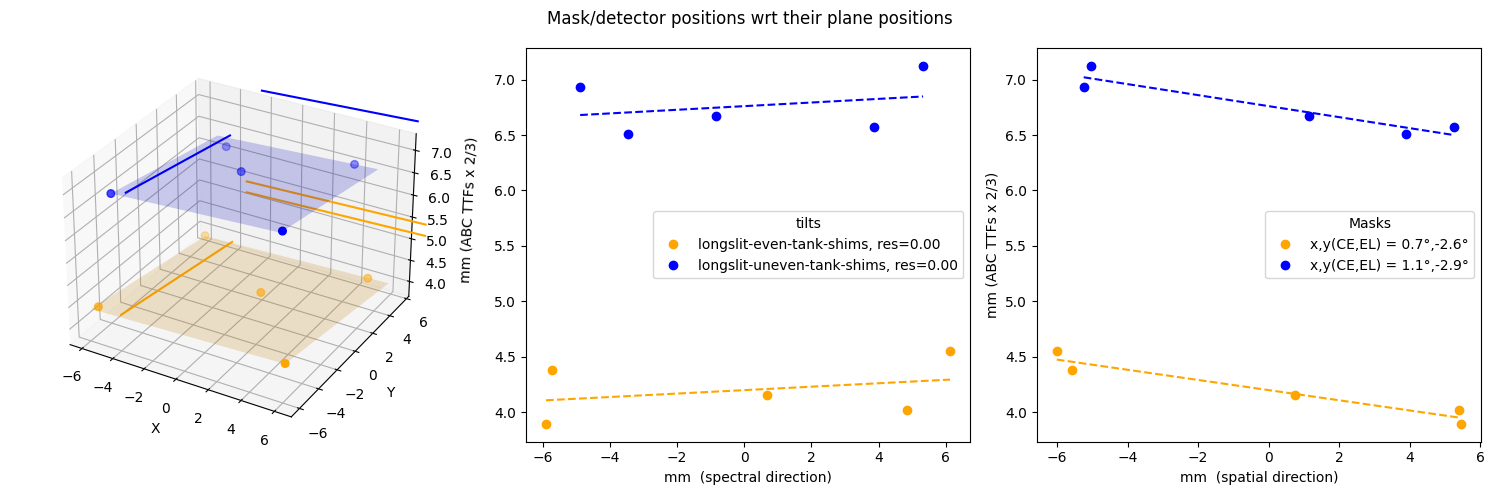

In [49]:
%matplotlib widget
import sys
# sys.path.insert(0,'/content/pyds9plugin')
from astropy.table import Table
import matplotlib.pyplot as plt
import glob
import numpy as np
# from google.colab import drive
# from google.colab import files

from pyds9plugin.DS9Utils import PlotFit1D

def fit_quadratic_curve(x, y, z, sigma_z=None, order=2, Plot=True, n=100, ax=None, c="r", title=None,legend=""):
    """Linear or quadratic fit of data
    """
    import matplotlib
    import matplotlib.cm as cmx
    from scipy import linalg

    cm = plt.get_cmap("twilight_shifted")
    cNorm = matplotlib.colors.Normalize(vmin=1, vmax=4)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    if sigma_z is None:
        index = np.isfinite(z)
        #        data = np.array(zip(x[index],y[index],z[index]))
        data = np.array([x[index], y[index], z[index]]).T
    else:
        index = (np.isfinite(z)) & (np.isfinite(sigma_z))
        data = np.array(zip(x[index], y[index], z[index] / sigma_z[index]))
    # regular grid covering the domain of the data
    X, Y = np.meshgrid(np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n))
    # X, Y = np.meshgrid(np.linspace(0, x.max(), n), np.linspace(0, y.max(), n))
    XX = X.flatten()
    YY = Y.flatten()

    order = order  # 1: linear, 2: quadratic
    if order == 1:
        # best-fit linear plane
        if sigma_z is None:
            A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        else:
            A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])] / sigma_z[:, np.newaxis]

        C, _, _, _ = linalg.lstsq(A, data[:, 2])  # coefficients
        # evaluate it on grid
        Z = C[0] * X + C[1] * Y + C[2]
        z_plane = C[0] * x + C[1] * y + C[2]
        res = np.sum(np.square(z - z_plane))
        # or expressed using matrix/vector product
        # Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)
        l ="%s: Z = %0.4f * X + %0.4f * Y +%0.1f\nangles x,y(CE,EL) = %0.1fdeg,%0.1fdeg"%(legend,C[0], C[1], C[2],180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi)
    elif order == 2:
        if sigma_z is None:
            # best-fit quadratic curve
            A = np.c_[np.ones(data.shape[0]), data[:, :2], np.prod(data[:, :2], axis=1), data[:, :2] ** 2]
        else:
            # best-fit quadratic curve
            A = np.c_[np.ones(data.shape[0]), data[:, :2], np.prod(data[:, :2], axis=1), (data[:, :2] ** 2)] / sigma_z[:, np.newaxis]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        # evaluate it on a grid
        Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX * YY, XX ** 2, YY ** 2], C).reshape(X.shape)
        z_plane = np.dot(np.c_[np.ones(x.shape), x, y, x * y, y ** 2, y ** 2], C).reshape(X.shape)
        res = np.sum(np.square(z - z_plane))
        l = C
    if Plot:
        if ax is None:
            fig = plt.figure()#figsize=(15, 10))  # (10,8)
            # ax = fig.gca(projection="3d")
            ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2,color = c)
        # ax.contour3D(X, Y, Z, 55, cmap=c)#cmap="twilight_shifted")
        # ax.scatter(data[:, 0], data[:, 1], z[index], s=20, c=scalarMap.to_rgba(z[index]))  # cmap='twilight_shifted',vmin=1,vmax=4)
        ax.scatter(data[:, 0], data[:, 1], z[index], s=30, color=c,label=l)  # cmap='twilight_shifted',vmin=1,vmax=4)
        ax.contour(X, Y, Z, zdir='x', offset=-4, colors=[c,c],levels=1)#[X.min(),X.max()])
        ax.contour(X, Y, Z, zdir='y', offset=   10, colors=[c,c],levels=1)#[Y.min(),Y.max()])

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.legend(fontsize=8)
        ax.set_zlabel("Z")
        # scalarMap.set_array(z[index])
        try:
            fig.colorbar(scalarMap)#, fraction=0.016, pad=-0.2
        except UnboundLocalError:
            pass
        ax.axis("tight")
        if title is not None:
            ax.set_title(title)
    else:
        ax = 1
    return X, Y, Z, ax, C, res
#MGS raised 400mu
#detector lowered by 230 mu

def plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/*/", factor = 2/3,n=1, z_direction=None,title=None):
    c="k"    
    cat = Table( names=("name", "cx", "cy", "c0","tx","ty"),dtype=[str,float,float,float,float,float])
    fig = plt.figure(figsize=(15,5))#,sharey=True, subplot_kw={'projection': "3d"})
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax0 = fig.add_subplot(1, 3, 2)
    ax1 = fig.add_subplot(1, 3, 3)
    # fig = plt.figure(figsize=(5,15))#,sharey=True, subplot_kw={'projection': "3d"})
    # ax = fig.add_subplot(3, 1, 1, projection='3d')
    # ax0 = fig.add_subplot(3, 1, 2)
    # ax1 = fig.add_subplot(3, 1, 3)

    for folder,c in zip(glob.glob(path)[:],["orange","b","k","g","r","grey","brown"]*10):
        x,y,z=[],[],[]
        files = glob.glob(folder + "/**/**/*_cat.fits")
        if len(files)>4:
            for f in files:
                a = Table.read(f)
                i =float(a["Center"][0])*n
                x.append(float(a["X_IMAGE_PSF"][0])*0.013)
                y.append(float(a["Y_IMAGE_PSF"][0])*0.013)
                type = "guider" if "LINAENC" in a.colnames else "detector"
                if z_direction is None:
                    if "LINAENC" in a.colnames:
                        Amin,Bmin,Cmin = float(a["LINAENC"][0]), float(a["LINBENC"][0]), float(a["LINCENC"][0])
                        Amax,Bmax,Cmax = float(a["LINAENC"][-1]), float(a["LINBENC"][-1]), float(a["LINCENC"][-1])
                        AS,BS,CS = np.linspace(Amin,Amax,11*n), np.linspace(Bmin,Bmax,11*n), np.linspace(Cmin,Cmax,11*n)
                        zi = factor * (float(AS[int(i)])+float(BS[int(i)])+float(CS[int(i)]))/ 3
                        # type="guider"
                    else:
                        A,B,C = 17.25, 15.75, 12.25 
                        A,B,C = 15.7, 14.5, 10.1
                        A,B,C = 15.2,	10.5,	9.95
                        # AS,BS,CS = np.linspace(A-5*0.25,A+5*0.25,11), np.linspace(B-5*0.25,B+5*0.25,11), np.linspace(C-5*0.25,C+5*0.25,11)
                        AS,BS,CS = np.linspace(A+5*0.25,A-5*0.25,11*n), np.linspace(B+5*0.25,B-5*0.25,11*n), np.linspace(C+5*0.25,C-5*0.25,11*n)
                        # zis = np.linspace(,,11)
                        # i = np.argmin(a["FWHM_IMAGE"])
                        zi = factor *(AS[int(i)]+BS[int(i)]+CS[int(i)])/ 3
                        # type="detector"
                        # zi = np.min(a["FWHM_IMAGE"])
                        # x.append(a["x_real_center"][0])
                        # y.append(a["y_real_center"][0])
                else:
                    zi = np.min(a[z_direction])
                z.append(zi)
            x = np.array(x) - np.mean(x)
            y = np.array(y) - np.mean(y)
            # x -= np.mean(x)
            # y -= np.mean(y)
            if type=="detector":
                x+=1000*0.013/4
                # y*=-1

            X, Y, Z, ax, C, res = fit_quadratic_curve(np.array(x), np.array(y), np.array(z), sigma_z=None, order=1, Plot=True, n=100, ax=ax, c=c, title=None,legend=folder.split("/")[-2].split("_")[-1])

            if z_direction is None:
                label = "x,y(CE,EL) = %0.1f°,%0.1f°"%(180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi)
            else:
                label = "Z = %0.4f  X + %0.4f  Y +%0.1f"%(C[0], C[1], C[2])

            cat.add_row([folder.split("/")[-1],C[0], C[1], C[2],180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi])
            
            l = ax0.plot(np.array(x),  np.array(z),"o",c=c,label=folder.split("/")[-2].split("_")[-1] + ", res=%0.2f"%(res))
            a = PlotFit1D(np.array(x),  np.array(z), ax=ax0, deg=1, plot_=True, ls="--",c=l[0].get_color(),extrapolate=False)#,lw=lw,sigma=err[mask ])
            ax1.plot(np.array(y),  np.array(z),"o",c=c, label = label)
            a = PlotFit1D(np.array(y),  np.array(z), ax=ax1, deg=1, plot_=True, ls="--",c=l[0].get_color(),extrapolate=False)#,lw=lw,sigma=err[mask ])
        
        if z_direction is None:
            ax.set_zlabel("mm (ABC TTFs x 2/3)")#("ROT = %s"%(folder.split("/")[-1]))
            # ax.set_title("Mask/detector positions wrt their plane positions")
            # ax1.set_ylabel("mm  (ABC TTFs x 2/3)")
            ax1.set_ylabel("mm (ABC TTFs x 2/3)")
        else:
            ax.set_zlabel(z_direction)
            ax1.set_ylabel(z_direction)
            # ax.set_title("Mask/detector positions wrt their plane positions")

    ax1.legend(title="Masks")
    ax0.legend(title="tilts")
    # ax.set_title("ROT = %s"%(folder.split("/")[-2]))
    # ax.set_zlim((7.6,10.6))

    # ax.set_xlim((-4,6))
    # ax.set_ylim((-7.5,10))


    ax1.set_xlabel("mm  (spatial direction)")
    ax0.set_xlabel("mm  (spectral direction)")
    fig.suptitle(title)
    fig.tight_layout()

    plt.savefig(folder + "/Focal_plane_fit.png", dpi=100, bbox_inches="tight")
    # plt.savefig(os.path.dirname(folder) + "/Focal_plane_fit_%s.png"%(folder.split("/")[-1]))
    cat.to_pandas().to_clipboard()
    plt.show()
    return fig, (ax, ax0, ax1)
        
fig, (ax, ax0, ax1) = plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_-*long*/",title="Mask/detector positions wrt their plane positions",n=10,factor=0.8*2/3)#, z_direction="FWHM_IMAGE")

# fig, (ax, ax0, ax1) = plot_masks()
# fig, (ax, ax0, ax1) = plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/R*/", z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'")

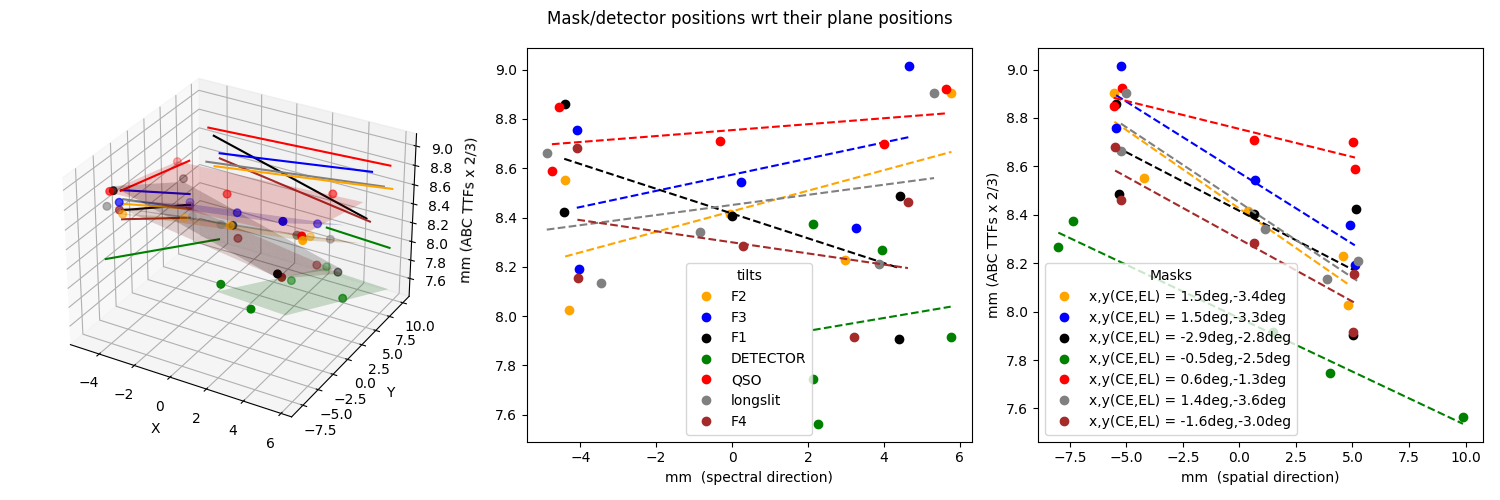

In [30]:
fig, (ax, ax0, ax1) = plot_masks(title="Mask/detector positions wrt their plane positions",n=10,factor=0.8*2/3)



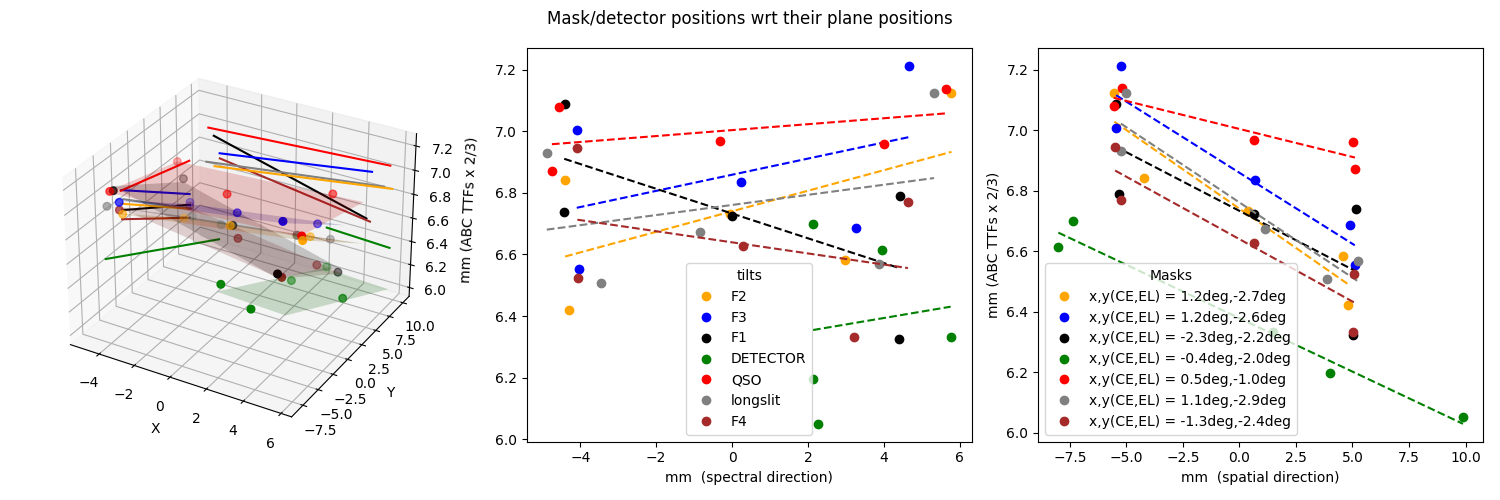

In [31]:
fig, (ax, ax0, ax1) = plot_masks(title="Mask/detector positions wrt their plane positions",n=10,factor=0.8*2/3)


In [ ]:
    # for folder,c in zip(glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/DETECTOR/")[:],["orange","b","k","g","r","orange"]):
    # folder = "/Users/Vincent/DS9QuickLookPlugIn/subsets/confocality_masks/DETECTOR"
        # for f in glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230425/through_focus/?/*_cat.fits"):
        # for f in glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230525/dets/*_cat.fits"):
        # paths=glob.glob("/Users/Vincent/DS9QuickLookPlugIn/subsets/230413_16H00m22/ROTENC_-20.99998/**/**/Th*.csv")
        # stack_images_path(paths, Type="nanmean", clipping=3, dtype=float, fname="", std=False, name=None)    
            # print(f)
            # a = Table.read(os.path.dirname(paths[0])+"/stack_cat.csv")
